## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import os
import math
import warnings
import numpy as np 
import pandas as pd 
from glob import glob
from random import sample 
%matplotlib inline
import matplotlib.pyplot as plt
from skimage import io
import scipy
import sklearn.model_selection as skl
from itertools import chain
from random import sample 

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

from sklearn.preprocessing import binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
# Load the NIH image data set into 
all_train_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_train_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_train_image_paths), ', Total Headers', all_train_xray_df.shape[0])
all_train_xray_df['path'] = all_train_xray_df['Image Index'].map(all_train_image_paths.get)
all_train_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
80925,00019889_004.png,Atelectasis,4,19889,33,M,AP,3056,2544,0.139,0.139,NaN,/data/images_009/images/00019889_004.png
38746,00010120_002.png,No Finding,2,10120,48,M,PA,2992,2991,0.143,0.143,NaN,/data/images_005/images/00010120_002.png
81699,00020094_004.png,Edema,4,20094,44,M,AP,3056,2544,0.139,0.139,NaN,/data/images_009/images/00020094_004.png


In [3]:
# Creating some extra columns in the table above to has some binary indicators of certain diseases.
# We need this so we don't manipulate the findings column directly

#Let us show how many diseases we hav in total
findings = set()
for f in all_train_xray_df['Finding Labels'].unique():
    findings.update(f.split('|'))
print(f'Total number of single diagnoses: {len(findings)}')
findings

Total number of single diagnoses: 15


{'Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax'}

In [4]:
# Create a column for each of the findings in table
for finding in findings:
    all_train_xray_df[finding] = all_train_xray_df['Finding Labels'].map(lambda x: 1.0 if finding in x else 0)

all_train_xray_df.head(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Nodule,Edema,No Finding,Effusion,Fibrosis,Cardiomegaly,Atelectasis,Emphysema,Pneumothorax,Mass
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [5]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

all_train_xray_df['pneumonia_class'] = all_train_xray_df.apply(lambda x: 'Y' if x['Pneumonia'] == 1.0 else 'N', axis=1)
all_train_xray_df.head(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Edema,No Finding,Effusion,Fibrosis,Cardiomegaly,Atelectasis,Emphysema,Pneumothorax,Mass,pneumonia_class
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,N
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,N
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,N


## Create your training and testing data:

In [6]:
def create_splits(**vargs):
    
    ## This function will help us create the standard and recommended train and test data sets. We will greatly consider 
    ## How imbalanced or balanced we will need to setup the data for the classification of Pneumonia
    
    df = vargs['df']
    
    train_df, valid_df = skl.train_test_split(df, test_size = 0.2, stratify = df['pneumonia_class'])
    train_df_ratio = len(train_df[train_df['pneumonia_class'] == 'Y'])/len(train_df)
    valid_df_ratio = len(valid_df[valid_df['pneumonia_class'] == 'Y'])/len(valid_df)
    print(f'Splitted pneumonia set. Train data: {100.0*train_df_ratio :.2f}%. Test data: {100.0*valid_df_ratio :.2f}%')
    
    # make training set contain same number of positive and negative cases
    train_pos_inds = train_df[train_df['pneumonia_class'] == 'Y'].index.tolist()
    train_neg_inds = train_df[train_df['pneumonia_class'] == 'N'].index.tolist()

    train_neg_sample = sample(train_neg_inds, len(train_pos_inds))
    train_df = train_df.loc[train_pos_inds + train_neg_sample]

    train_df_ratio = len(train_df[train_df['pneumonia_class'] == 'Y'])/len(train_df)
    print(f'Train set normalized (50/50), pneumonia: {100.0*train_df_ratio :.2f}%')
    
    # make test set contain 80% positive and 20% negative cases
    valid_pos_inds = valid_df[valid_df['pneumonia_class'] == 'Y'].index.tolist()
    valid_neg_inds = valid_df[valid_df['pneumonia_class'] == 'N'].index.tolist()

    valid_neg_sample = sample(valid_neg_inds, 4*len(valid_pos_inds))
    valid_df = valid_df.loc[valid_pos_inds + valid_neg_sample]

    valid_df_ratio = len(valid_df[valid_df['pneumonia_class'] == 'Y'])/len(valid_df)
    print(f'Test set normalized (20/80), pneumonia: {100.0*valid_df_ratio :.2f}%')

    return train_df, valid_df

In [7]:
## Invoke above function and print out the Train and Test data sizes
train_df, valid_df = create_splits(df = all_train_xray_df)
print(f'Train data size: {len(train_df)}, Test data size: {len(valid_df)}')

Splitted pneumonia set. Train data: 1.28%. Test data: 1.28%
Train set normalized (50/50), pneumonia: 50.00%
Test set normalized (20/80), pneumonia: 20.00%
Train data size: 2290, Test data size: 1430


In [8]:
## Export the test data set for further research during inferencing
valid_df.to_csv('pneumonia_test_data.csv')

#### Here will define some Image manipulation and data shuffling functions and begin image augmentation and introspection

In [9]:
## These set of functions below will help augment and extract our train and test data

## most common image size used for augmentation
IMAGE_SIZE = (224, 224)

def my_image_augmentation(**vargs):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations keeping an eye out for some type of augmentation that is not appropriate
    
    rotation = vargs['rotation'] if 'rotation' in vargs else 20
    shear = vargs['shear'] if 'shear' in vargs else 0.1
    zoom = vargs['zoom'] if 'rotation' in vargs else 0.1
    
    gen = ImageDataGenerator(
        rescale=1. / 255.0, 
        horizontal_flip = True, 
        vertical_flip = False, 
        height_shift_range = 0.1, 
        width_shift_range = 0.1, 
        rotation_range = rotation, 
        shear_range = shear,
        zoom_range = zoom)
    
    return gen


def make_train_gen(**vargs):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data using 
    ## using the flow_from_dataframe library from Keras

    df = vargs['df']
    
    aug = my_image_augmentation(**vargs)
    
    train_gen = aug.flow_from_dataframe(
        dataframe = df, 
        directory = None, 
        x_col = 'path',
        y_col = 'pneumonia_class',
        class_mode = 'binary',
        target_size = IMAGE_SIZE, 
        batch_size = 32)

    return train_gen


def make_valid_gen(**vargs):

    df = vargs['df']
    
    val_idg = ImageDataGenerator(rescale=1. / 255.0)
    
    valid_gen = val_idg.flow_from_dataframe(
        dataframe = df, 
        directory = None, 
        x_col = 'path',
        y_col = 'pneumonia_class',
        class_mode = 'binary',
        target_size = IMAGE_SIZE, 
        batch_size = 1024)
    
    return valid_gen

In [10]:
## This function will help shuffle our train data to add more variation to batches during epochs for different learning rates
## And also dropout values
def shuffle_frame(data):
    #using numpy permutation
    return data.iloc[np.random.permutation(len(data))]

In [11]:
## Process The images now to get standardized train and test data no need to shuffle train data since its the first batch run
train_gen = make_train_gen(df = train_df)
valid_gen = make_valid_gen(df = valid_df)

Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [12]:
## Pull a single large batch of random validation data for testing after each epoch:
valX, valY = valid_gen.next()

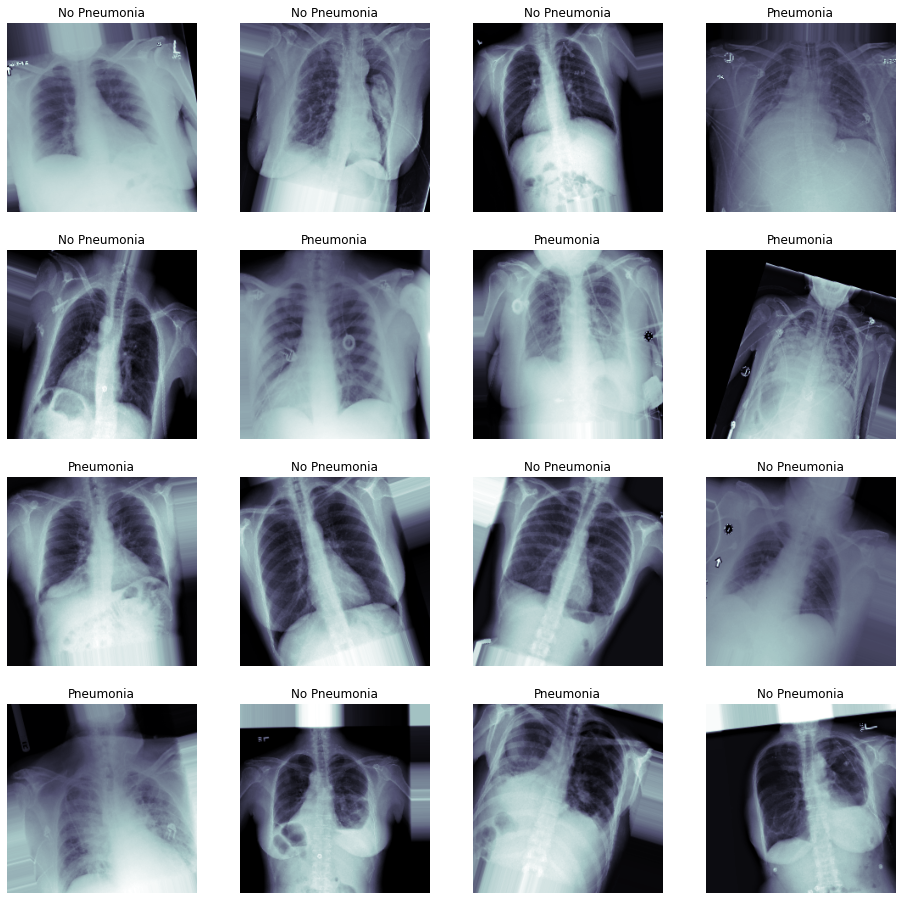

In [13]:
## Let us look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16)) 
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')
    
plt.show()

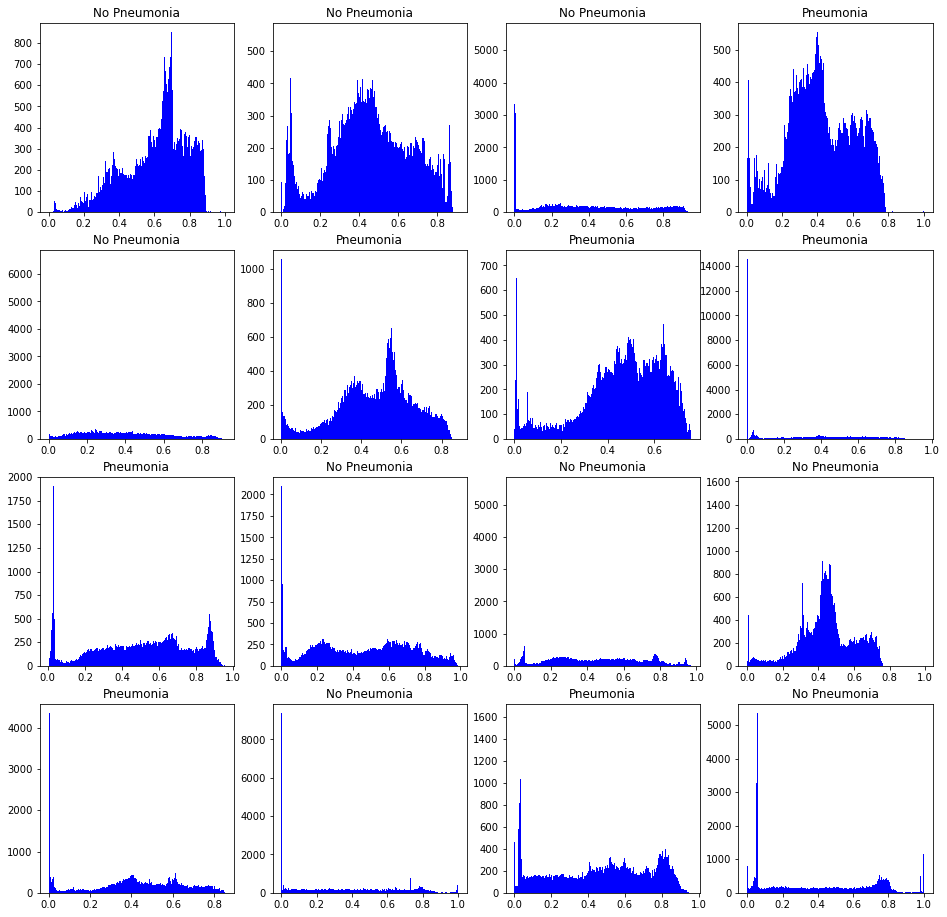

In [14]:
## Also show the image intensities

fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.hist(c_x[:,:,0].flatten(), bins = 256, color='blue')
    
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')

plt.show()

# Now we can begin our model-building & training

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [15]:
## Now let us create a function to load a VGG16 with pretrained image weights choosing a layer of interest
def load_pretrained_model(**vargs):
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # trainable
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    
    print('VGG16 layers:')
    for layer in vgg_model.layers:
        print(layer.name, layer.trainable)
        
    return vgg_model


In [16]:
## Time to build our new model's architecture from the pretrained model loaded above
def build_my_model(**vargs):

    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    
    vgg_model = load_pretrained_model()
    
    new_model = Sequential()
    new_model.add(vgg_model)
    
    do = vargs['do']

    # Flatten the output of the VGG16 model because it is from a convolutional layer.
    new_model.add(Flatten())
    new_model.add(Dropout(do))
    new_model.add(Dense(1024, activation='relu'))
    new_model.add(Dropout(do))
    new_model.add(Dense(512, activation='relu'))
    new_model.add(Dropout(do))
    new_model.add(Dense(256, activation='relu'))
    new_model.add(Dropout(do))
    #new_model.add(Dense(1, activation='relu'))    

    new_model.add(Dense(1, activation='sigmoid'))
    
    return new_model

In [17]:
## build and dispslay model architecture using a dropout of 0.5
model = build_my_model(do = 0.5)
model.summary()

553467904/553467096 [==============================] - 8s 0us/step
VGG16 layers:
input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)     

### Start training! 

In [18]:
# define learning rate of 4, loss, metrics and compile
optimizer = Adam(lr=1e-4)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

# define callbacks
weight_path="{}_model.best.hdf5".format('pneumonia')
checkpoint = ModelCheckpoint(weight_path, monitor = 'val_loss', mode = 'min', verbose = 1, save_best_only = True, save_weights_only = True)
early = EarlyStopping(monitor = 'val_loss', mode = 'min', patience=10)
callbacks_list = [checkpoint, early]

# train your model
history = model.fit_generator(
    train_gen, 
    validation_data = (valX, valY), 
    epochs = 100,
    callbacks = callbacks_list)

Epoch 1/100
72/72 [==============================] - 73s 1s/step - loss: 0.8703 - binary_accuracy: 0.4961 - val_loss: 0.6921 - val_binary_accuracy: 0.5264

Epoch 00001: val_loss improved from inf to 0.69212, saving model to pneumonia_model.best.hdf5
Epoch 2/100
72/72 [==============================] - 60s 839ms/step - loss: 0.7389 - binary_accuracy: 0.5275 - val_loss: 0.6464 - val_binary_accuracy: 0.7061

Epoch 00002: val_loss improved from 0.69212 to 0.64643, saving model to pneumonia_model.best.hdf5
Epoch 3/100
72/72 [==============================] - 60s 839ms/step - loss: 0.7057 - binary_accuracy: 0.5354 - val_loss: 0.6206 - val_binary_accuracy: 0.6963

Epoch 00003: val_loss improved from 0.64643 to 0.62059, saving model to pneumonia_model.best.hdf5
Epoch 4/100
72/72 [==============================] - 60s 832ms/step - loss: 0.6978 - binary_accuracy: 0.5498 - val_loss: 0.6711 - val_binary_accuracy: 0.5918

Epoch 00004: val_loss did not improve from 0.62059
Epoch 5/100
72/72 [=======

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Show some performance statistics of the current model by plotting some performance graph

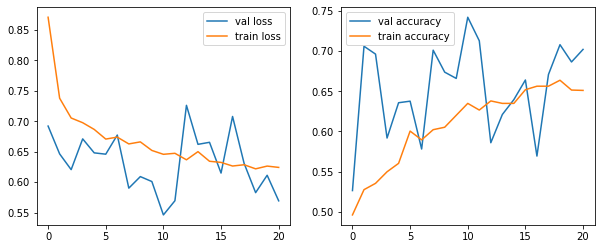

In [19]:
f = plt.figure()
f.set_figwidth(10)
f.add_subplot(1, 2, 1)
plt.plot(history.history['val_loss'], label='val loss')
plt.plot(history.history['loss'], label='train loss')
plt.legend()

f.add_subplot(1, 2, 2)
plt.plot(history.history['val_binary_accuracy'], label='val accuracy')
plt.plot(history.history['binary_accuracy'], label='train accuracy')
plt.legend()

plt.show()

In [20]:
## Let us make some predictions to assess the model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
model.load_weights(weight_path)
pred_Y = model.predict(valX, batch_size = 32, verbose = True)

1024/1024 [==============================] - 10s 9ms/step


In [21]:
## Some function that will help us plot some very vital grapyical representations
def plot_auc(t_y, p_y):
    fpr, tpr, thresholds = roc_curve(t_y, p_y, pos_label=1)
    plt.plot(fpr, tpr, color='red', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve')    
    plt.show()

## We will also look at Precision and Recall and F1 Score

def plot_pr(t_y, p_y):
    precision, recall, thresholds = precision_recall_curve(t_y, p_y, pos_label=1)
    plt.plot(recall, precision, color='red', lw=2)
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.title('Precision-Recall Curve')
    plt.show()

def calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)

    
# Also consider plotting the history of your model training:

def plot_history(history):
    return

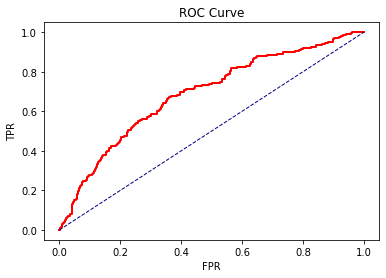

In [22]:
## Plot ROC Curve
plot_auc(valY, pred_Y)

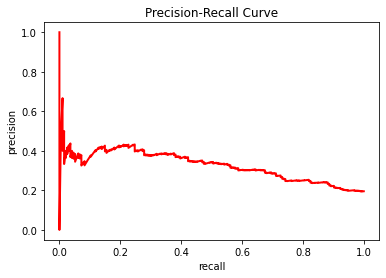

In [23]:
## Plot Precision Recall
plot_pr(valY, pred_Y)

Text(0.5, 1.0, 'Precision/Recall by threshold')

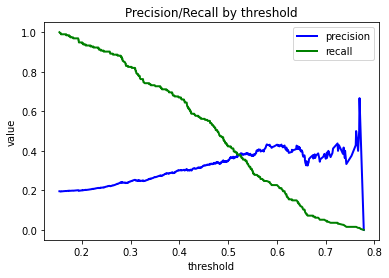

In [24]:
## Show precision recall by threshold
precision, recall, thresholds = precision_recall_curve(valY, pred_Y, pos_label=1)
plt.plot(thresholds, precision[:-1], color='blue', lw=2, label='precision')
plt.plot(thresholds, recall[:-1], color='green', lw=2, label='recall')
plt.legend()
plt.xlabel('threshold')
plt.ylabel('value')
plt.title('Precision/Recall by threshold')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


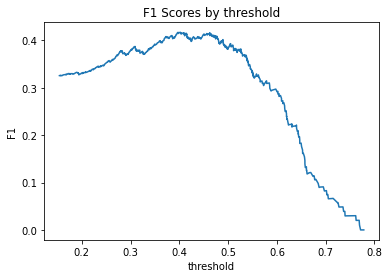

In [25]:
## Show F1 Score by threshold

def f1(threshold):
    for i,t in enumerate(thresholds):
        if t > threshold:
            f1score = calc_f1(precision[i], recall[i])
            if not math.isnan(f1score):
                return f1score
            else: 
                return 0
    return 0

f1scores = [f1(t) for t in thresholds]
plt.plot(thresholds, f1scores)
plt.title('F1 Scores by threshold')
plt.xlabel('threshold')
plt.ylabel('F1')
plt.show()

In [26]:
## Print maximum f1 score, threshold, precision and recall
ind = np.argmax(np.array(f1scores, dtype=np.float32))
f1 = f1scores[ind]
print(f'Max F1 score: {f1 :.3f}, threshold: {thresholds[ind] :.3f}, precision: {precision[ind] :.3f}, recall: {recall[ind] :.3f}')

Max F1 score: 0.417, threshold: 0.402, precision: 0.302, recall: 0.670


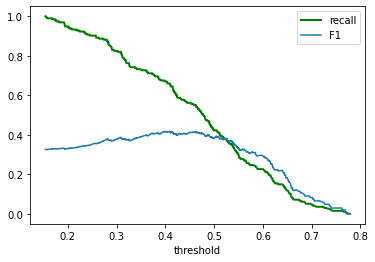

In [27]:
## Plot F1 alongside Threshold
plt.plot(thresholds, recall[:-1], color='green', lw=2, label='recall')
plt.plot(thresholds, f1scores, label='F1')
plt.xlabel('threshold')
plt.legend()
plt.show()

In [28]:
## This function will help us determine the best threshold for our model
def get_index(th):
    for i,t in enumerate(thresholds):
        if t > th:
            return i

print(f'Recall: {recall[get_index(0.29)] :.3f}, precision: {precision[get_index(0.29)] :.3f}, F1: {f1scores[get_index(0.29)] :.3f}, threshold: {thresholds[get_index(0.29)] :.3f}')
print(f'Recall: {recall[get_index(0.3)] :.3f}, precision: {precision[get_index(0.3)] :.3f}, F1: {f1scores[get_index(0.3)] :.3f}, threshold: {thresholds[get_index(0.3)] :.3f}')
print(f'Recall: {recall[get_index(0.31)] :.3f}, precision: {precision[get_index(0.31)] :.3f}, F1: {f1scores[get_index(0.31)] :.3f}, threshold: {thresholds[get_index(0.31)] :.3f}')
print(f'Recall: {recall[get_index(0.33)] :.3f}, precision: {precision[get_index(0.33)] :.3f}, F1: {f1scores[get_index(0.33)] :.3f}, threshold: {thresholds[get_index(0.33)] :.3f}')
print(f'Recall: {recall[get_index(0.35)] :.3f}, precision: {precision[get_index(0.35)] :.3f}, F1: {f1scores[get_index(0.35)] :.3f}, threshold: {thresholds[get_index(0.35)] :.3f}')

Recall: 0.840, precision: 0.239, F1: 0.370, threshold: 0.290
Recall: 0.825, precision: 0.246, F1: 0.379, threshold: 0.300
Recall: 0.809, precision: 0.252, F1: 0.382, threshold: 0.310
Recall: 0.742, precision: 0.250, F1: 0.374, threshold: 0.330
Recall: 0.727, precision: 0.267, F1: 0.391, threshold: 0.351


In [29]:
## Determine confusion matrix
tn, fp, fn, tp = confusion_matrix(valY, (pred_Y > 0.3).astype(int)).ravel()
tn, fp, fn, tp

(339, 491, 34, 160)

### We need to change our model architecture by reducing the dropouts and increasing the learning rate

In [33]:
## Lets shuffle the training set to add some variation for the next epoch
train_df2 = shuffle_frame(train_df)
train_gen2 = make_train_gen(df = train_df2)

Found 2290 validated image filenames belonging to 2 classes.


In [34]:
## build and dispslay second model architecture using a dropout of 0.2
model2 = build_my_model(do = 0.2)
model2.summary()

VGG16 layers:
input_4 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_4 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 25088)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 1024)              25691136  
_____________________

In [35]:
# define learning rate of 5, loss, metrics for the second model and compile
optimizer = Adam(lr=1e-5)
model2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

# define callbacks
weight_path2="{}_model.best.hdf5".format('pneumonia2')
checkpoint = ModelCheckpoint(weight_path2, monitor = 'val_loss', mode = 'min', verbose = 1, save_best_only = True, save_weights_only = True)
early = EarlyStopping(monitor = 'val_loss', mode = 'min', patience=10)
callbacks_list = [checkpoint, early]

# train your model
history2 = model2.fit_generator(
    train_gen2, 
    validation_data = (valX, valY), 
    epochs = 100,
    callbacks = callbacks_list)

Epoch 1/100
72/72 [==============================] - 69s 955ms/step - loss: 0.7251 - binary_accuracy: 0.5227 - val_loss: 0.7963 - val_binary_accuracy: 0.2393

Epoch 00001: val_loss improved from inf to 0.79634, saving model to pneumonia2_model.best.hdf5
Epoch 2/100
72/72 [==============================] - 60s 832ms/step - loss: 0.6827 - binary_accuracy: 0.5646 - val_loss: 0.7124 - val_binary_accuracy: 0.5264

Epoch 00002: val_loss improved from 0.79634 to 0.71238, saving model to pneumonia2_model.best.hdf5
Epoch 3/100
72/72 [==============================] - 59s 823ms/step - loss: 0.6935 - binary_accuracy: 0.5450 - val_loss: 0.7060 - val_binary_accuracy: 0.5381

Epoch 00003: val_loss improved from 0.71238 to 0.70595, saving model to pneumonia2_model.best.hdf5
Epoch 4/100
72/72 [==============================] - 59s 824ms/step - loss: 0.6769 - binary_accuracy: 0.5817 - val_loss: 0.6739 - val_binary_accuracy: 0.5762

Epoch 00004: val_loss improved from 0.70595 to 0.67392, saving model to

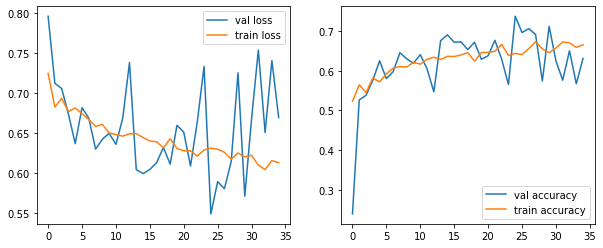

In [37]:
f = plt.figure()
f.set_figwidth(10)
f.add_subplot(1, 2, 1)
plt.plot(history2.history['val_loss'], label='val loss')
plt.plot(history2.history['loss'], label='train loss')
plt.legend()

f.add_subplot(1, 2, 2)
plt.plot(history2.history['val_binary_accuracy'], label='val accuracy')
plt.plot(history2.history['binary_accuracy'], label='train accuracy')
plt.legend()

plt.show()

In [38]:
## Let us make some predictions to assess the second model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
model2.load_weights(weight_path2)
pred_Y2 = model2.predict(valX, batch_size = 32, verbose = True)

1024/1024 [==============================] - 10s 9ms/step


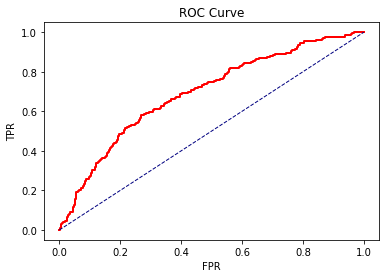

In [39]:
## Plot ROC Curve
plot_auc(valY, pred_Y2)

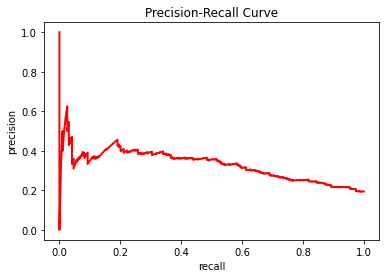

In [40]:
## Plot Precision Recall
plot_pr(valY, pred_Y2)

Text(0.5, 1.0, 'Precision/Recall by threshold')

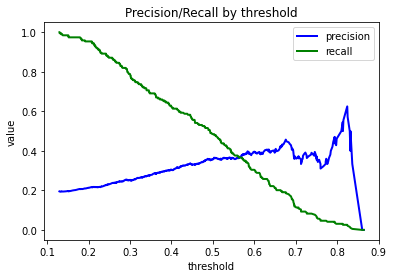

In [41]:
## Calculate and Plot precision recall by threshold
precision, recall, thresholds = precision_recall_curve(valY, pred_Y2, pos_label=1)
plt.plot(thresholds, precision[:-1], color='blue', lw=2, label='precision')
plt.plot(thresholds, recall[:-1], color='green', lw=2, label='recall')
plt.legend()
plt.xlabel('threshold')
plt.ylabel('value')
plt.title('Precision/Recall by threshold')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


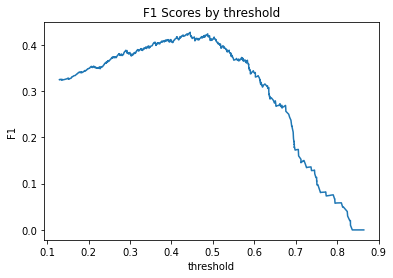

In [42]:
## Show F1 Score by threshold

def f1(threshold):
    for i,t in enumerate(thresholds):
        if t > threshold:
            f1score = calc_f1(precision[i], recall[i])
            if not math.isnan(f1score):
                return f1score
            else: 
                return 0
    return 0

f1scores = [f1(t) for t in thresholds]
plt.plot(thresholds, f1scores)
plt.title('F1 Scores by threshold')
plt.xlabel('threshold')
plt.ylabel('F1')
plt.show()

In [43]:
## Print maximum f1 score, threshold, precision and recall
ind = np.argmax(np.array(f1scores, dtype=np.float32))
f1 = f1scores[ind]
print(f'Max F1 score: {f1 :.3f}, threshold: {thresholds[ind] :.3f}, precision: {precision[ind] :.3f}, recall: {recall[ind] :.3f}')

Max F1 score: 0.427, threshold: 0.445, precision: 0.336, recall: 0.582


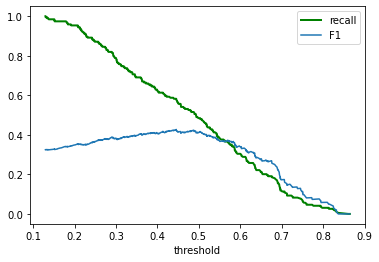

In [44]:
## Plot F1 alongside Threshold
plt.plot(thresholds, recall[:-1], color='green', lw=2, label='recall')
plt.plot(thresholds, f1scores, label='F1')
plt.xlabel('threshold')
plt.legend()
plt.show()

In [45]:
## This function will help us determine the best threshold for our model
def get_index(th):
    for i,t in enumerate(thresholds):
        if t > th:
            return i

print(f'Recall: {recall[get_index(0.29)] :.3f}, precision: {precision[get_index(0.29)] :.3f}, F1: {f1scores[get_index(0.29)] :.3f}, threshold: {thresholds[get_index(0.29)] :.3f}')
print(f'Recall: {recall[get_index(0.3)] :.3f}, precision: {precision[get_index(0.3)] :.3f}, F1: {f1scores[get_index(0.3)] :.3f}, threshold: {thresholds[get_index(0.3)] :.3f}')
print(f'Recall: {recall[get_index(0.31)] :.3f}, precision: {precision[get_index(0.31)] :.3f}, F1: {f1scores[get_index(0.31)] :.3f}, threshold: {thresholds[get_index(0.31)] :.3f}')
print(f'Recall: {recall[get_index(0.33)] :.3f}, precision: {precision[get_index(0.33)] :.3f}, F1: {f1scores[get_index(0.33)] :.3f}, threshold: {thresholds[get_index(0.33)] :.3f}')
print(f'Recall: {recall[get_index(0.35)] :.3f}, precision: {precision[get_index(0.35)] :.3f}, F1: {f1scores[get_index(0.35)] :.3f}, threshold: {thresholds[get_index(0.35)] :.3f}')

Recall: 0.814, precision: 0.253, F1: 0.387, threshold: 0.290
Recall: 0.789, precision: 0.253, F1: 0.381, threshold: 0.300
Recall: 0.758, precision: 0.256, F1: 0.383, threshold: 0.311
Recall: 0.727, precision: 0.267, F1: 0.388, threshold: 0.330
Recall: 0.691, precision: 0.278, F1: 0.397, threshold: 0.350


In [46]:
## Determine confusion matrix
tn, fp, fn, tp = confusion_matrix(valY, (pred_Y2 > 0.3).astype(int)).ravel()
tn, fp, fn, tp

(379, 451, 41, 153)

As you can see the second model hase more true negatives and lesser false positives and we can get much higher recall with comparatively very small loss in precision, and F1 score, e.g. for threshold = 0.3 Clearly, this comes at a cost of high number of false positives, the model generally has low precision.

In [47]:
## Choose the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

YOUR_THRESHOLD = 0.3
testY = valY

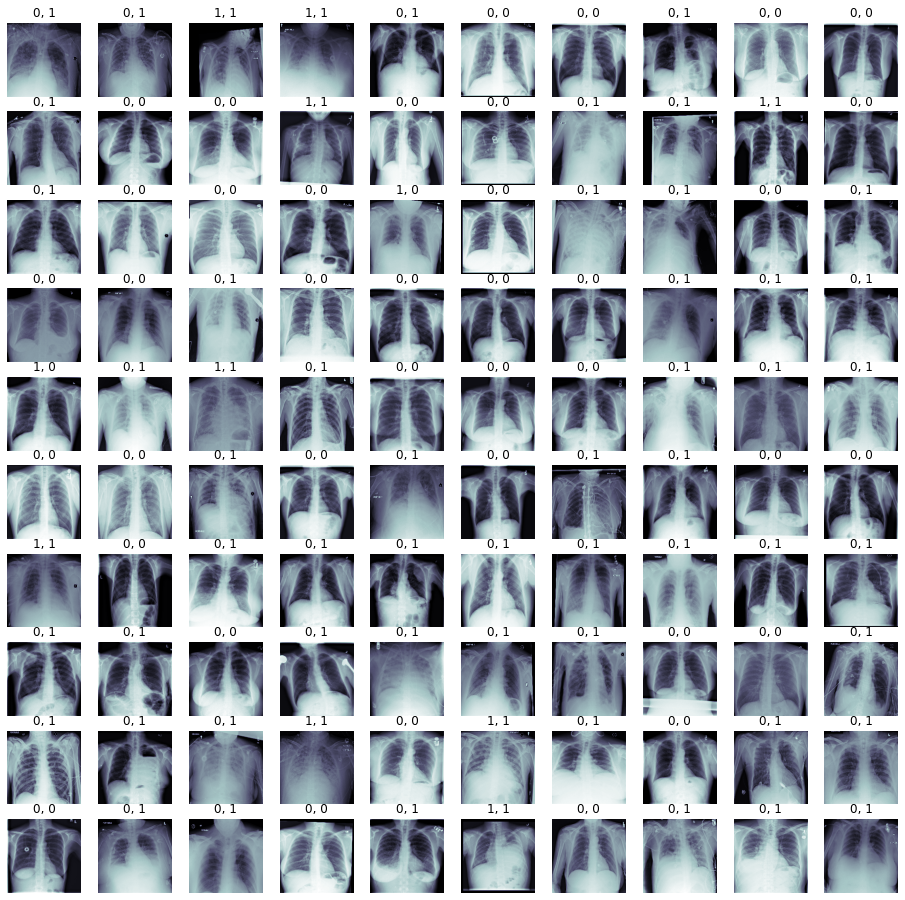

In [48]:
## Let's look at some examples of true vs. predicted with our best model: 

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y2[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y2[i] > YOUR_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

Just like we were expecting, we see large number of false positives, but very low number of false negatives, this is the major determinant of what can be achieved clinically with this model

In [49]:
## We can now save the best model architecture to .json for inferencing
model_json = model2.to_json()
with open("pneumonia_final_model.json", "w") as json_file:
    json_file.write(model_json)

#### Summary
The model has good recall, but very low precision, which will lead to high number of false positives
Therefore, it should be used only as an assitance to a radiologist, putting to low priority queue those xrays that were classified as negative by the model.

To make model more useful (future research):
Remove extreme intensity areas (no light, or too intensive light) from images, or use gaussian blur

Vary hyper-parameters:
dropout rate,
augmentation parameters,
batch size,
learning rate

Use additional info from the dataset during training (multi-input architecture)